# AIPI 590 Assignment 6 – Explainable AI II

### Jason Lee

For this assignment, we explore the use of ICE, PDP, and ALE plots as XAI techniques for a Random Forest model fitted for a California House Price prediction task.

The California Housing dataset, which we use scikit-learn to import, is derived from the 1990 US census bureau, where 8 features describe ~20K "blocks" of regions in California.

More information about the dataset can be found at: https://scikit-learn.org/1.5/datasets/real_world.html#california-housing-dataset

<a target="_blank" href="https://colab.research.google.com/github/choonghwanlee/explainableai-2-aipi590-f24">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
## Install Packages
%pip install alibi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Successfully uninstalled attrs-24.2.0
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.24.0
    Uninstalling scikit-image-0.24.0:
      Successfully uninstalled scikit-image-0.24.0


In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [ ]:
import pandas as pd
features = pd.DataFrame(housing['data'], columns=housing['feature_names'])

In [ ]:
target = housing['target']

In [ ]:
housing['target_names']

['MedHouseVal']

###  EDA – Feature Correlation

We will determine the amount of correlation between our features by plotting a heatmap of pearson correlation

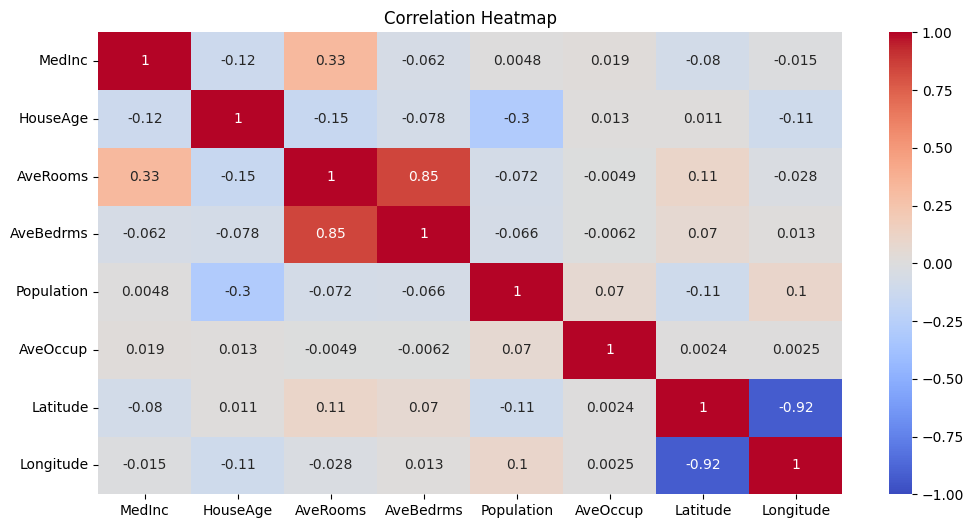

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = features.corr()

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

#### Conclusion:

We note that there is some multicollinarity issues in the dataset, specifically for latitude & longitude + average rooms & average bedrooms, which are highly correlated with one another. Otherwise, house age and population + average rooms and median income are two pairs of features that are exhibit moderate collinearity.

### Fitting a Model

We fit a Random Forest Regressor to our dataset as a predictor. For the sake of computational simplicity, we fit a tree with a max depth of 10 (default value is 100).

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(features.values, target)

RandomForestRegressor(max_depth=10, random_state=0)

### ICE & PDP Plots with Scikit-Learn

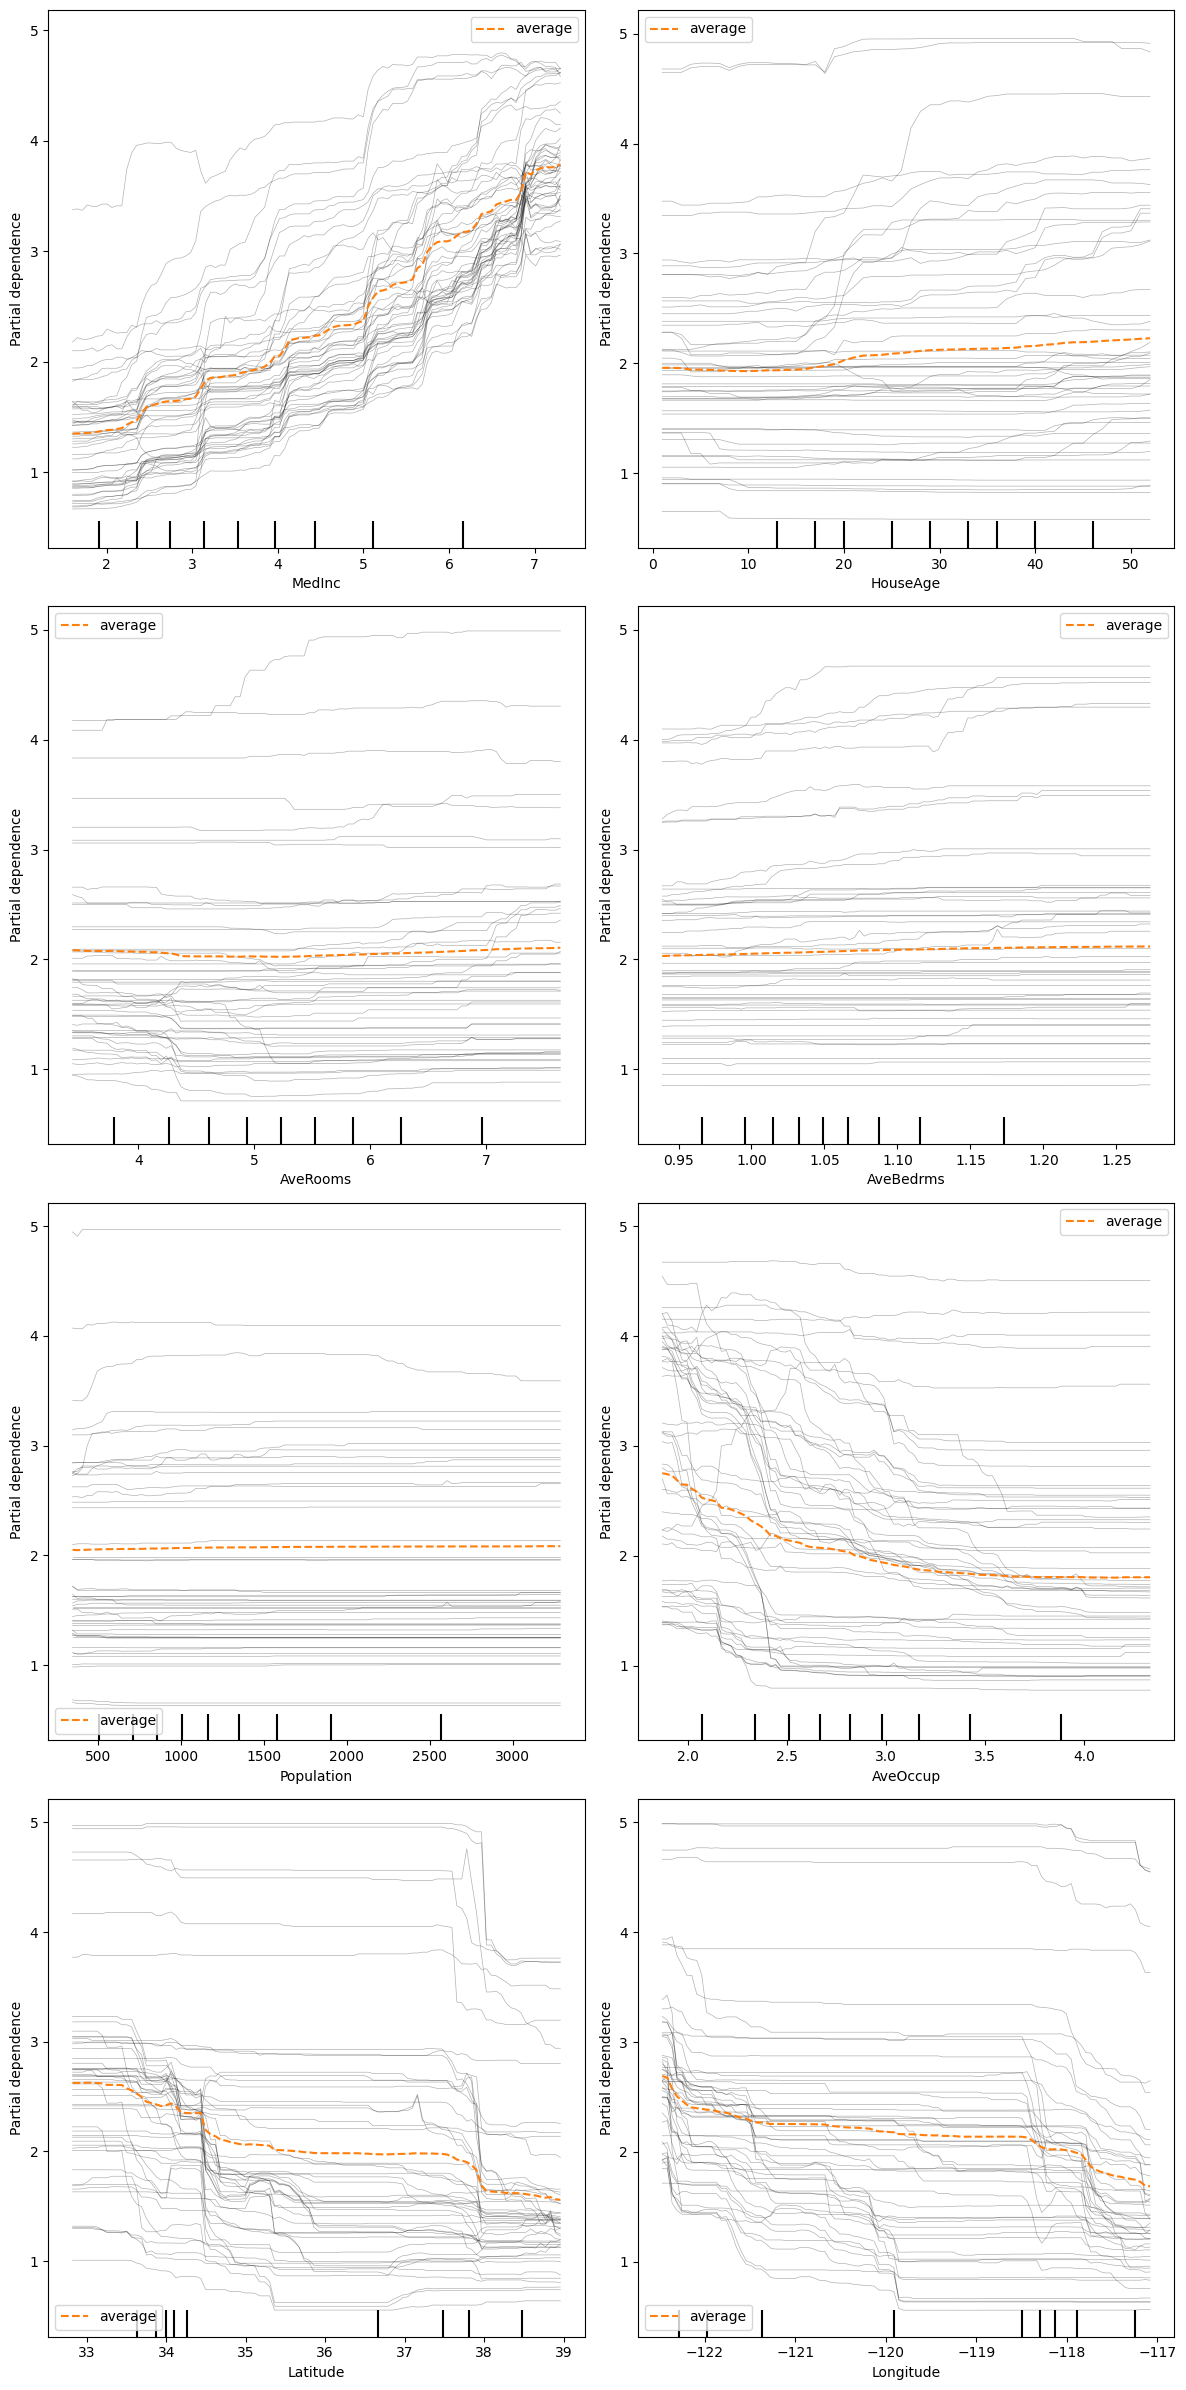

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(nrows=4, ncols = 2, figsize = (12, 24))
axes = axes.flatten()

for i, ax in enumerate(axes[:8]):
    PartialDependenceDisplay.from_estimator(regr, features.values, [i], feature_names= features.columns.tolist(), kind='both', ice_lines_kw={'color':'black'}, subsample=50, ax=ax)

plt.tight_layout()
plt.show()

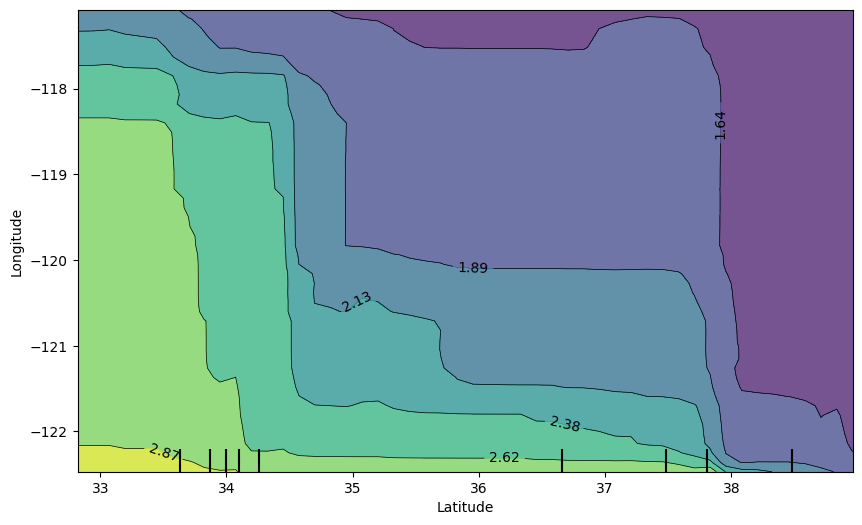

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(regr, features.values, [('Latitude', 'Longitude')], feature_names = features.columns.tolist(), ax=ax, grid_resolution=50)
plt.show()


#### Interpretation:

Each subplot in the first chart above shows both the ICE and PDP plots for a given feature. The PDP plot, which is just the average of the ICE plots, is highlighted in a yellow dashed line (and gives us an overview of the average effect/dependence).

We note that the feature with greatest importance is Median Income. Generally speaking, as median income increases, median house value also increases in a largely linear fashion. The relationship also slightly resembles that of a step function, where sharp increases in median house value are followed by a flattening slope.

Due to the multicollinearity in latitude & longitude + average rooms & average bedrooms, we cannot reliably draw interpretations from those feature's PDP/ICE plots as they are not independent (meaning true marginal effects cannot be measured through ICE/PDP).  

We also plot a 2D PDP plot of longitude and latitude, whch allows us to examine the effects of geography in a more nuisanced way. We note an interesting pattern where median house value is greatest as we move more west and south. This generally corresponds to the LA/Irvine/San Diego region, where house values are known to be high.

### ALE Plots with Alibi

Alibi is a popular Python XAI library with a built-in implementation of ALE plots.

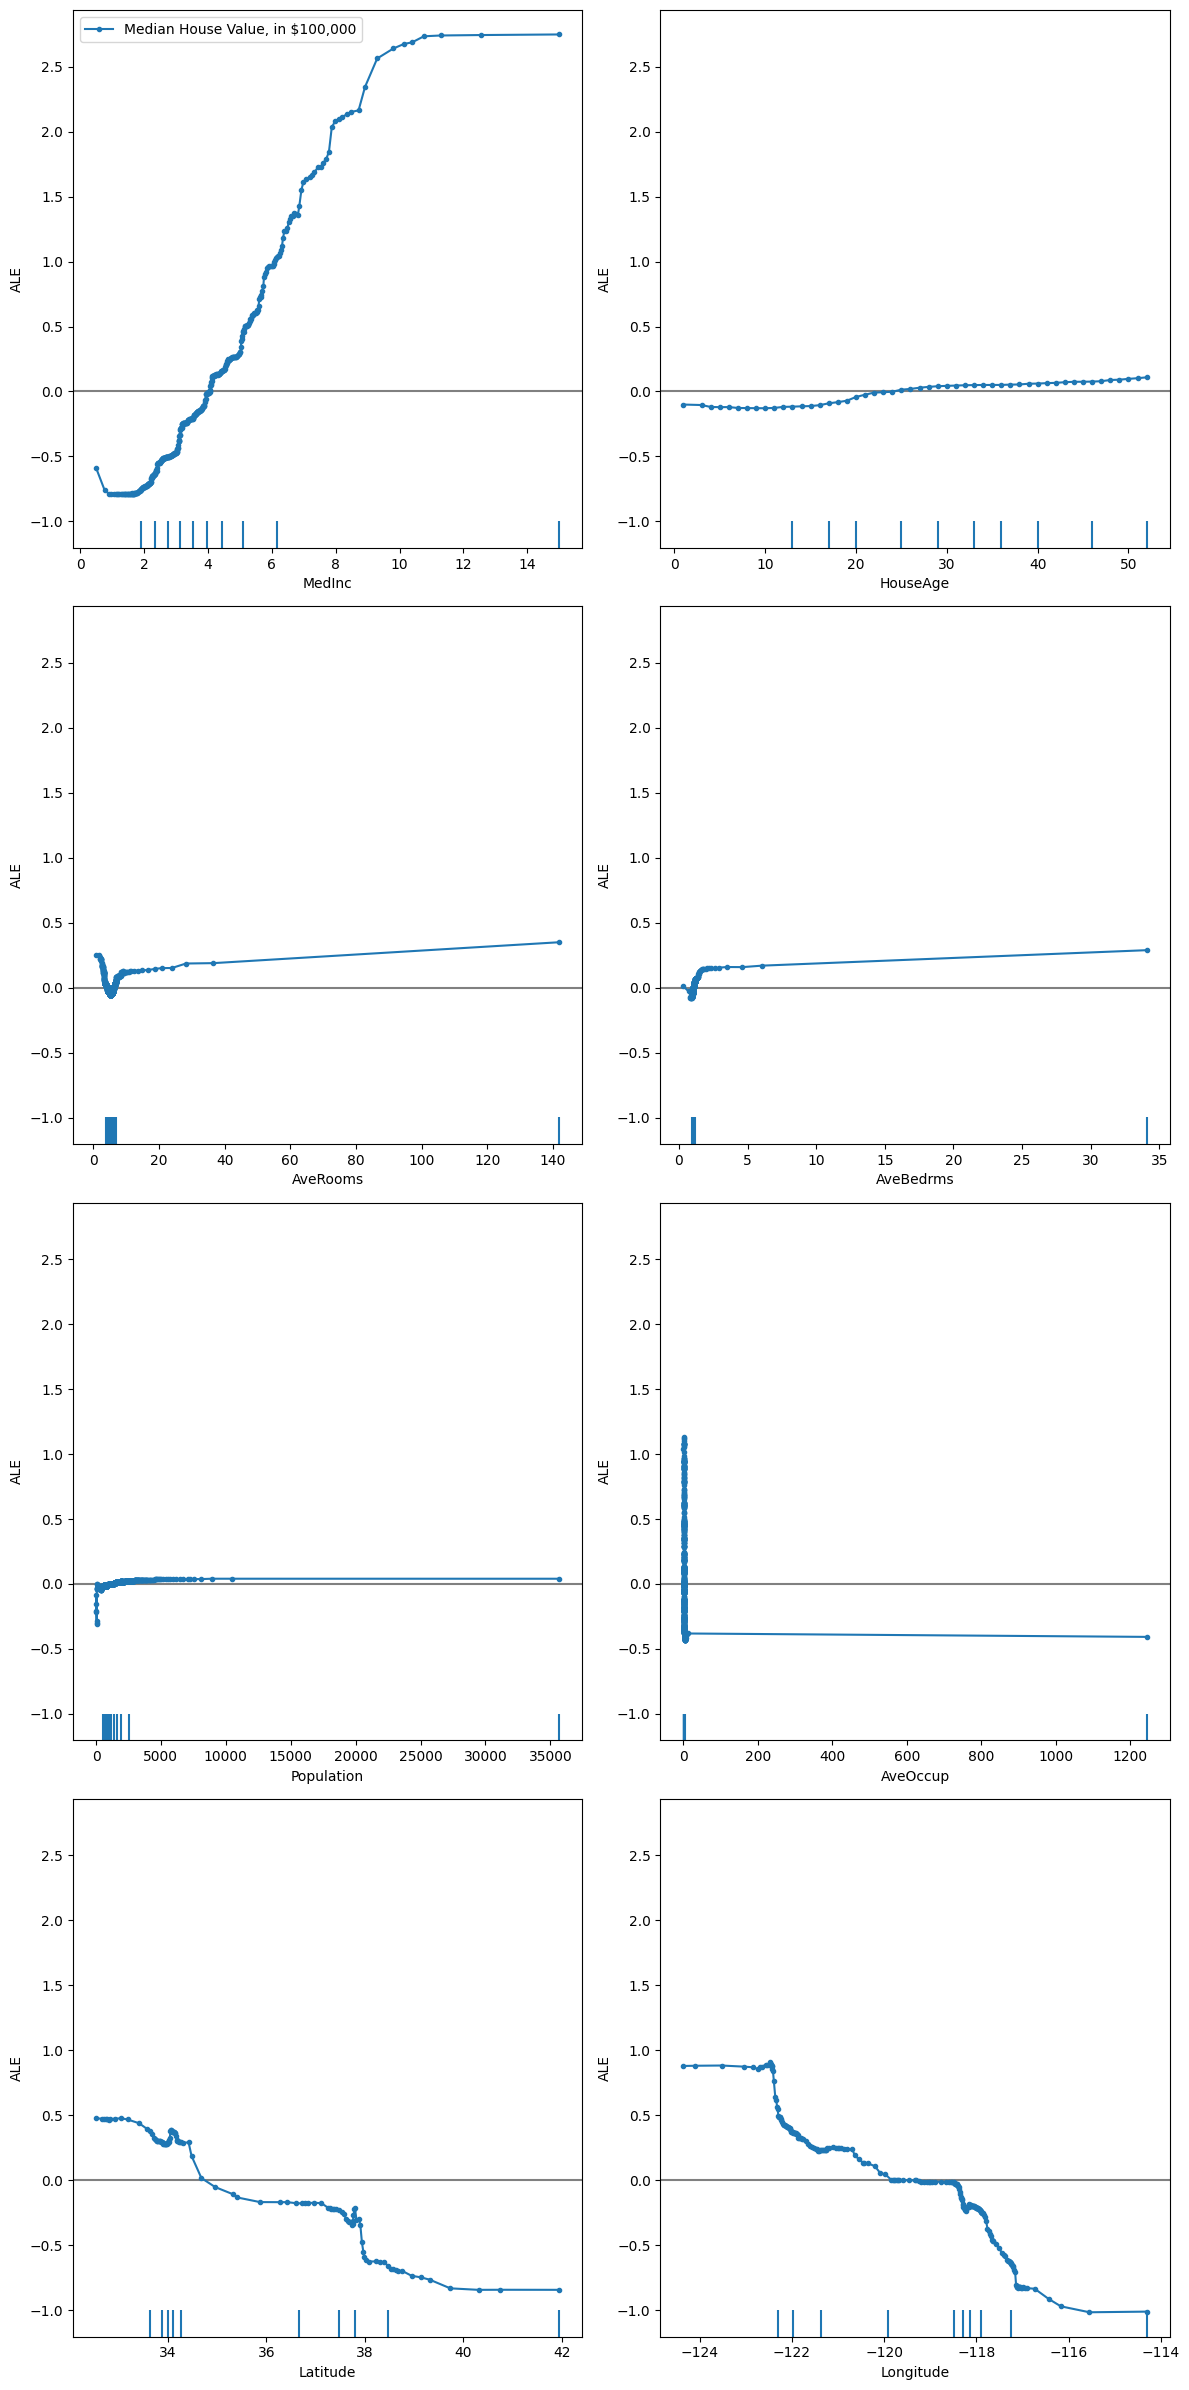

In [ ]:
from alibi.explainers import ALE, plot_ale

ale = ALE(regr.predict, feature_names=features.columns.tolist(), target_names=['Median House Value, in $100,000'])
ale_exp = ale.explain(features.values)

# Plot ALE
plot_ale(ale_exp, n_cols=2, fig_kw={'figwidth': 12, 'figheight': 24});

#### Interpretation:

Each subplot above shows both the ALE plot for a given feature.

We note that the ALE and PDP/ICE plots are largely the same. This is likely because there isn't too much multicollinearity in our data, as observed by our EDA of pearson correlation between features.

Median income continues to have the largest impact on the median house income. Specifically, for blocks with a median income less than 4, median house value is less than the average. On the other hand, houses with median income greater than 4 have a higher-than-average median house value, with the greatest difference being ~250K USD.

We see that the shape of some of the plots change, however, mostly due to the differing domain of the plot. Specifically, we note that for population, average occupancy, average rooms, and average bedrooms, there seems to be an outlier in the far right that shifts the shape of the ALE plot.

For non-linear models like Random Forests, such linear interpolation in feature areas with no data can be unreliable, making us cautious in drawing immediate conclusions from the ALE plots.